# 🧭 Cell and metadata annotation using PANGEApy

This tutorial demonstrates how to perform **both cell-level** and **metadata-level** annotation using the `PANGEApy` framework.  

The analysis includes two main steps:

1. **Cell type annotation** using the universal PANGEA reference model  
2. **Metadata annotation** (organ and phenotype prediction) using the inferred cellular composition

By the end of this vignette, you will understand how PANGEApy can generalize to unseen datasets and infer higher-level sample metadata from cell-level predictions.

## Environmental setup

We begin by importing essential packages for single-cell analysis and visualization,  
and by loading the core PANGEA-py modules:  
- `CellAnnotator` - predicts cell types using the PANGEA atlas-based model.  
- `MetaAnnotator` - predicts sample-level metadata such as organ and phenotype.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.verbosity = 0
sc.settings.set_figure_params(facecolor='white', frameon=False)
sns.set_style("white")

from pangeapy.cell import CellAnnotator
from pangeapy.meta import MetaAnnotator

cell_anno = CellAnnotator()
meta_anno = MetaAnnotator()

/home/smcheong/.local/lib/python3.11/site-packages/celltypist/classifier.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  from scanpy import __version__ as scv


Checking-up download status of anno_models
Checking-up download status of meta_models


## Load the Dataset

We use the public dataset from *Stephenson et al., 2021, Nature Medicine, "Single-cell multi-omics analysis of the immune response in COVID-19"*.  
The dataset was downloaded from **CellxGene** and preprocessed into an AnnData (`.h5ad`) object.

In [2]:
adata = sc.read(
    "/nfs/SCMGL/smc00_ref/2021_Stephenson_NatMed_COVID/e6b93598-7ae3-47d6-b971-d3c6d9162175.h5ad",
    cache=True
)

In [3]:
adata

AnnData object with n_obs × n_vars = 647366 × 24677
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_clustering', 'Resample', 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'donor_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'antibody_X', 'antibody_features', 'antibody_raw.X', 'citat

### Visualize author-provided metadata

The dataset includes sample-level annotations such as collection site and disease severity.

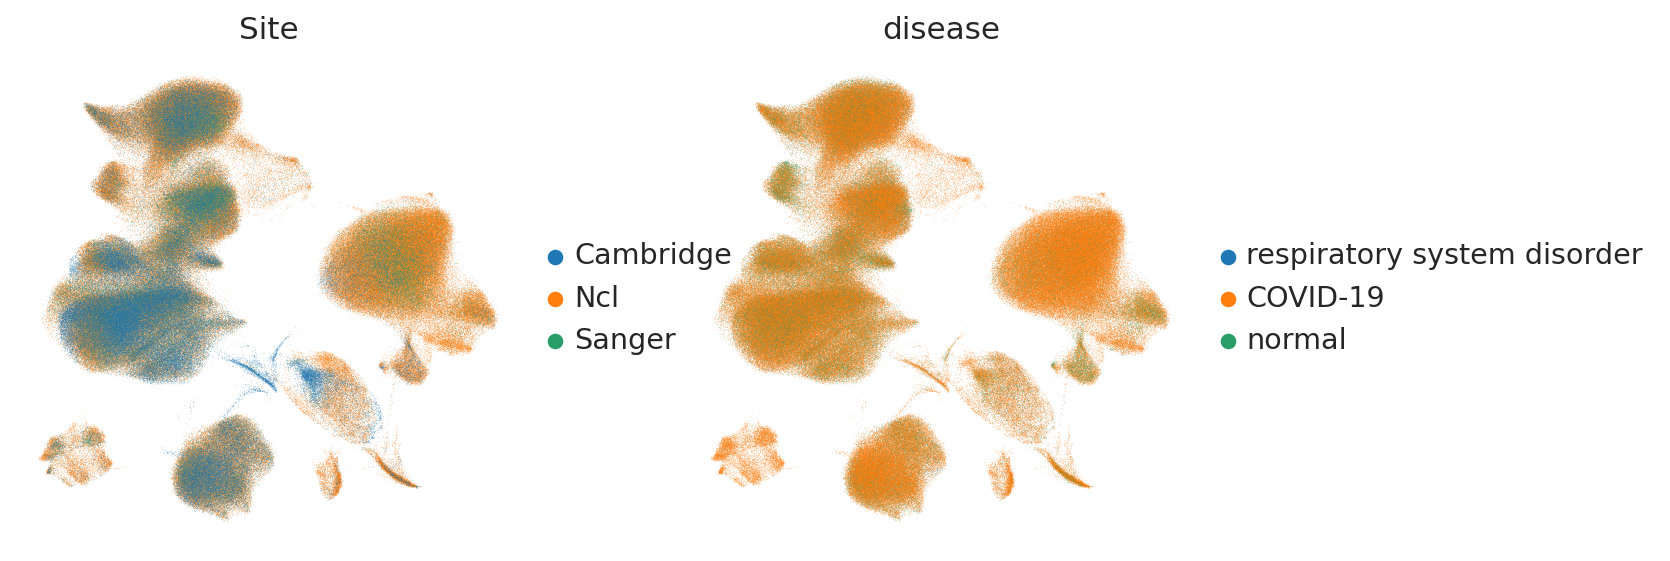

In [4]:
sc.pl.umap(adata, color=['Site', 'disease'])

The sample-level metadata was extracted from the AnnData object based on the `sample_id` field.

In [5]:
meta_df = pd.read_csv("/nfs/SCMGL/smc00_ref/2021_Stephenson_NatMed_COVID/meta.csv", index_col=0)
meta_df.head()

,Resample,Collection_Day,Swab_result,Status,Smoker,Status_on_day_collection,Status_on_day_collection_summary,Days_from_onset,Site,time_after_LPS,...,suspension_type,tissue_type,cell_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
sample_id,,,,,,,,,,,,,,,,,,,,,
MH9179824,Initial,D0,Positive,Covid,Non-smoker,Ward_O2,Moderate,8,Ncl,NaN,...,cell,tissue,"effector CD8-positive, alpha-beta T cell",10x 3' transcription profiling,COVID-19,female,blood,unknown,sixth decade stage,4N-=M7$oAz
newcastle65,Initial,D0,Healthy,Healthy,Not_known,Healthy,Healthy,Healthy,Ncl,NaN,...,cell,tissue,"naive thymus-derived CD4-positive, alpha-beta ...",10x 3' transcription profiling,normal,female,blood,unknown,sixth decade stage,lpGiUVfxXd
MH9143327,Initial,D0,Positive,Covid,Non-smoker,Ward_O2,Moderate,8,Ncl,NaN,...,cell,tissue,CD14-positive monocyte,10x 3' transcription profiling,COVID-19,male,blood,unknown,sixth decade stage,r#A?Fm&YUm
MH9143326,Initial,D0,Positive,Covid,Non-smoker,Ward_O2,Moderate,22,Ncl,NaN,...,cell,tissue,CD14-positive monocyte,10x 3' transcription profiling,COVID-19,male,blood,unknown,sixth decade stage,W=|(O>qU#y
MH9143325,Initial,D0,Positive,Covid,Non-smoker,ITU_NIV,Severe,7,Ncl,NaN,...,cell,tissue,"CD16-positive, CD56-dim natural killer cell, h...",10x 3' transcription profiling,COVID-19,female,blood,unknown,ninth decade stage,2eZ8^Eo69&


Since metadata annotation requires cell type labels predicted by `pangeapy`, we will first perform cell type annotation. If you have already completed cell type prediction, you may proceed directly to the **Metadata prediction with pangeapy** section.

## Prepare expression matrix and gene symbols

⚠️ **Important**:
- Pangeapy expects log1p-normalized expression scaled to 10,000 counts per cell.
- If you later modify `adata.X`, store the normalized expression in `adata.raw` to ensure compatibility.

In [6]:
print(adata.X.min(), adata.X.max())

0.0 9.070676


In [7]:
np.expm1(adata[:20,].X).sum(axis=1)

matrix([[10000.   ],
        [ 9992.398],
        [10000.   ],
        [ 9995.318],
        [ 9995.612],
        [10000.   ],
        [10000.   ],
        [ 9996.234],
        [10000.001],
        [ 9999.999],
        [10000.   ],
        [ 9999.999],
        [ 9999.999],
        [10000.   ],
        [10000.001],
        [10004.78 ],
        [10000.001],
        [10003.608],
        [ 9999.999],
        [ 9992.824]], dtype=float32)

We will also ensure that gene symbols are properly formatted and unique.

In [8]:
adata.var

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000243485,False,MIR1302-2HG,NCBITaxon:9606,gene,623,lncRNA
ENSG00000238009,False,ENSG00000238009,NCBITaxon:9606,gene,629,lncRNA
ENSG00000239945,False,ENSG00000239945,NCBITaxon:9606,gene,1319,lncRNA
ENSG00000239906,False,ENSG00000239906,NCBITaxon:9606,gene,323,lncRNA
ENSG00000229905,False,ENSG00000229905,NCBITaxon:9606,gene,456,lncRNA
...,...,...,...,...,...,...
ENSG00000277196,False,ENSG00000277196,NCBITaxon:9606,gene,2197,protein_coding
ENSG00000278384,False,ENSG00000278384,NCBITaxon:9606,gene,3027,protein_coding
ENSG00000277856,False,ENSG00000277856,NCBITaxon:9606,gene,294,protein_coding
ENSG00000275063,False,ENSG00000275063,NCBITaxon:9606,gene,351,protein_coding


In [9]:
adata.var = adata.var.reset_index(names='Ensembl').set_index('feature_name')

In [10]:
adata.var.index = adata.var.index.astype('string')

In [11]:
adata.var_names_make_unique()

In [12]:
print(sorted(set(adata.var.index))[:50])

['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2ML1-AS2', 'A3GALT2', 'A4GALT', 'AAAS', 'AACS', 'AADACL2-AS1', 'AADAT', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AANAT', 'AAR2', 'AARD', 'AARS2', 'AARSD1', 'AASDH', 'AASDHPPT', 'AASS', 'AATBC', 'AATF', 'AATK', 'ABALON', 'ABAT', 'ABCA1', 'ABCA10', 'ABCA12', 'ABCA13', 'ABCA2', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', 'ABCA7', 'ABCA8', 'ABCA9', 'ABCA9-AS1', 'ABCB1', 'ABCB10', 'ABCB11', 'ABCB4', 'ABCB5', 'ABCB6']


You can see here that while `adata.X` is scaled, the AnnData object stored in `adata.raw` contains log1p-normalized expression scaled to 10,000 counts per cell.

## Step 1 - Cell type annotation with PANGEApy

We first perform **cell-level annotation** using the universal PANGEA reference model.  
This assigns a hierarchical label structure - including Level1, Level2, and combined (`PG_annotations`) results — to each cell.

In [13]:
pred = cell_anno.annotate(adata, sample_key='sample_id')

processing MH9179824...[1/143]
conducting Level1 annotation...


/home/smcheong/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


conducting Level2 annotation...
processing newcastle65...[2/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH9143327...[3/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH9143326...[4/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH9143325...[5/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH9143320...[6/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH9143276...[7/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH9143274...[8/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH8919226...[9/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH9179821...[10/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH8919230...[11/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing MH9

conducting Level2 annotation...
processing BGCV02_CV0068...[88/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing BGCV02_CV0052...[89/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing BGCV02_CV0902...[90/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing BGCV02_CV0059...[91/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing BGCV03_CV0074...[92/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing BGCV03_CV0176...[93/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing BGCV03_CV0084...[94/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing BGCV03_CV0200...[95/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing BGCV04_CV0100...[96/143]
conducting Level1 annotation...
conducting Level2 annotation...
processing BGCV04_CV0262...[97/143]
conducting Level1 annotation...


Output columns `predicted_labels`, `majority_voting`, and `conf_score` follow the output format of CellTypist

In [14]:
pred.columns

Index(['Level1|predicted_labels', 'Level1|over_clustering',
       'Level1|majority_voting', 'Level1|conf_score', 'Level1|cert_score',
       'Level2|predicted_labels', 'Level2|over_clustering',
       'Level2|majority_voting', 'Level2|conf_score', 'Level2|cert_score',
       'PG_annotations', 'PG_combined_score', 'Sample'],
      dtype='object')

In [15]:
pred.head()

,Level1|predicted_labels,Level1|over_clustering,Level1|majority_voting,Level1|conf_score,Level1|cert_score,Level2|predicted_labels,Level2|over_clustering,Level2|majority_voting,Level2|conf_score,Level2|cert_score,PG_annotations,PG_combined_score,Sample
covid_index,,,,,,,,,,,,,
AAACCTGAGAAACCTA-MH9179824,T&NK,0,T&NK,0.999999,0.156115,T_CD8_EMRA,0,T_CD8_EMRA,0.999927,0.202715,T&NK|T_CD8_EMRA,0.999963,MH9179824
AAACCTGAGAGTAATC-MH9179824,T&NK,1,T&NK,0.999976,0.278088,T_CD4_EM_Th1,1,T_CD4_N&CM,0.885943,0.290980,T&NK|T_CD4_N&CM,0.941234,MH9179824
AAACCTGAGAGTGAGA-MH9179824,T&NK,3,T&NK,0.999976,0.402740,T_CD4_EM_Th22,1,T_CD4_N&CM,0.954359,0.457304,T&NK|T_CD4_N&CM,0.976901,MH9179824
AAACCTGAGGAATCGC-MH9179824,T&NK,4,T&NK,0.999999,0.193215,T_CD4_CXCL13,2,T_CD4_N&CM,0.495462,0.308035,T&NK|T_CD4_N&CM,0.703890,MH9179824
AAACCTGAGTGTTGAA-MH9179824,T&NK,7,T&NK,0.999999,0.337493,T_CD8_activated,4,T_CD4_N&CM,0.959132,0.186282,T&NK|T_CD4_N&CM,0.979352,MH9179824


The annotation results can be merged into the main AnnData object for visualization and downstream analyses.

In [16]:
adata.obs = pd.merge(
    adata.obs,
    pred.drop('Sample', axis=1),
    left_index=True, right_index=True, how='left'
)

In [17]:
adata

AnnData object with n_obs × n_vars = 647366 × 24677
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_clustering', 'Resample', 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'donor_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'Level1|predicted_labels', 'Level1|over_clustering', 'Level1|majority_voting', 'Level1|conf_score', 'Level1|cert_score', 'Level2|predicted_labels', 'Level2|over_clustering', 'Level2|majori

### Visualize results

The `PG_annotations` column represents the final annotation result from pangeapy, obtained by merging the Level1 and Level2 classification results.

... storing 'Level1|predicted_labels' as categorical
... storing 'Level1|over_clustering' as categorical
... storing 'Level1|majority_voting' as categorical
... storing 'Level2|predicted_labels' as categorical
... storing 'Level2|over_clustering' as categorical
... storing 'Level2|majority_voting' as categorical
... storing 'PG_annotations' as categorical


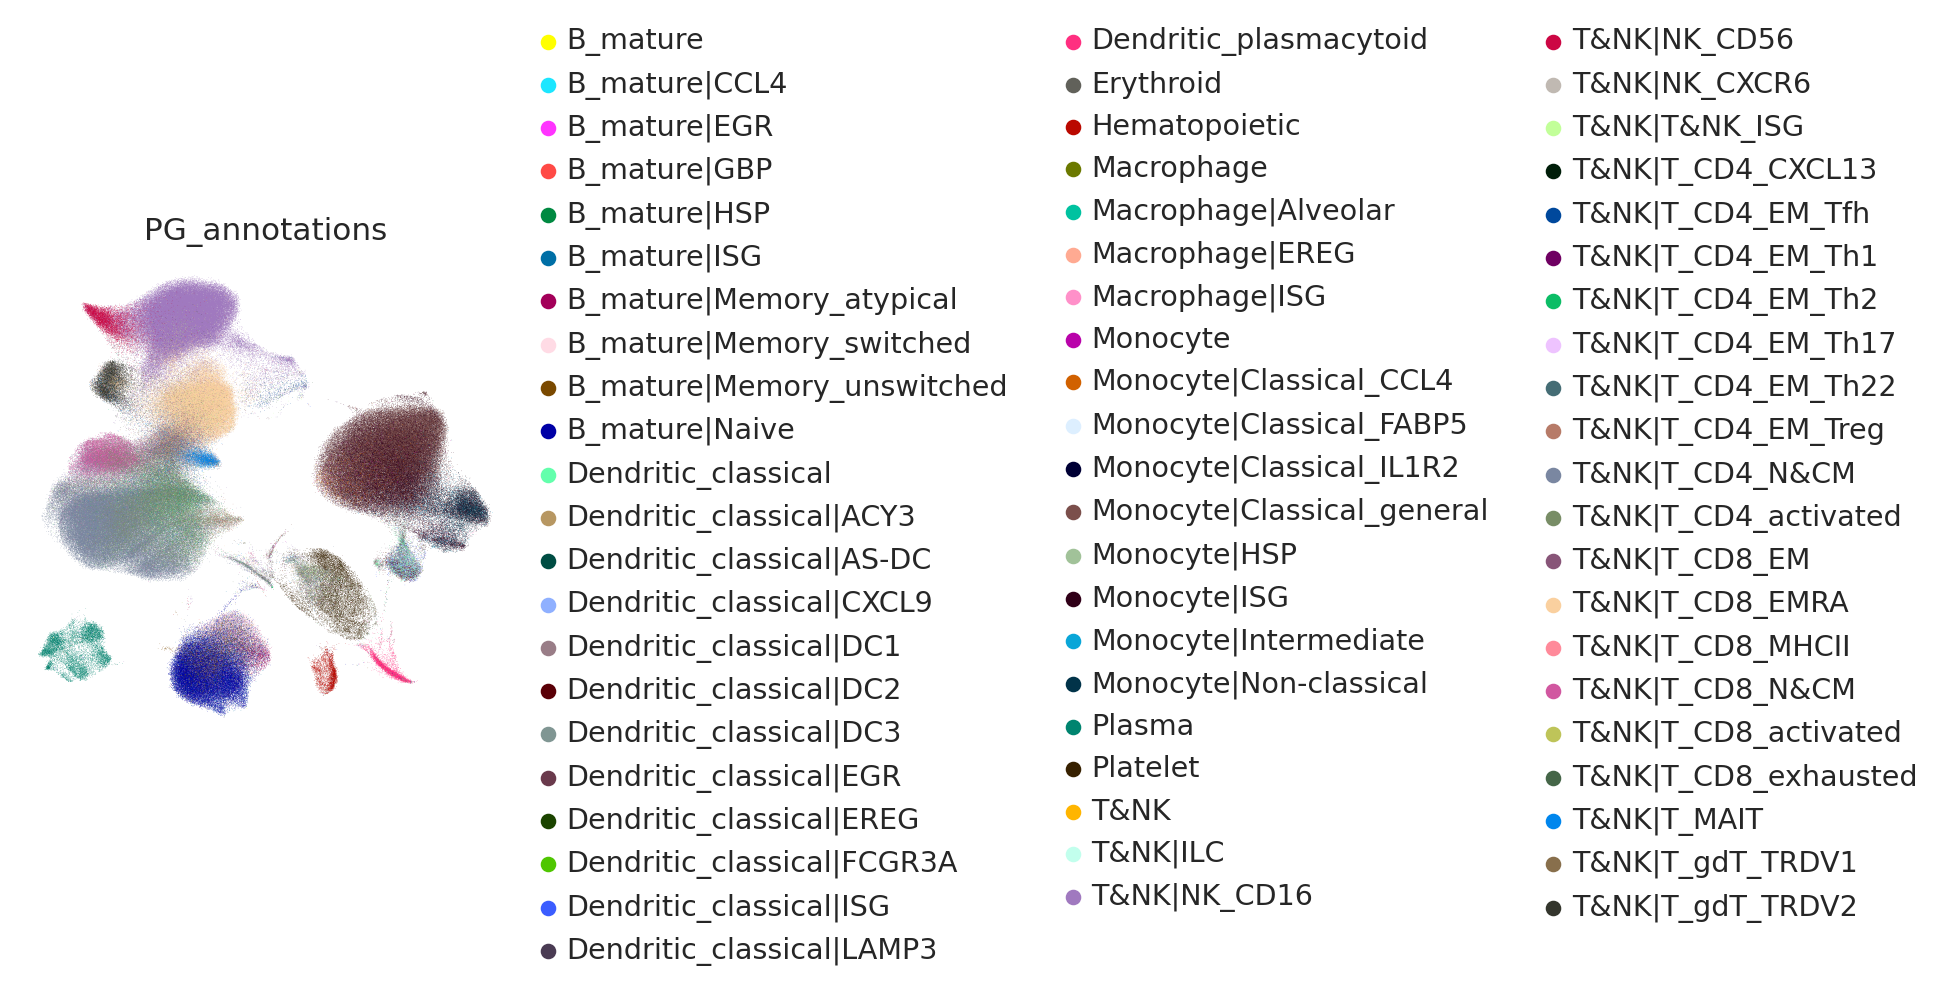

In [18]:
sc.pl.umap(adata, color='PG_annotations')

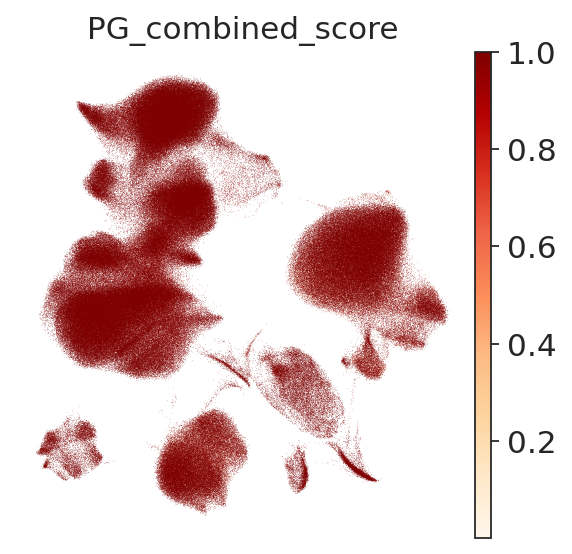

In [19]:
sc.pl.umap(adata, color='PG_combined_score', cmap='OrRd')

You can compare the result with the original annotation.

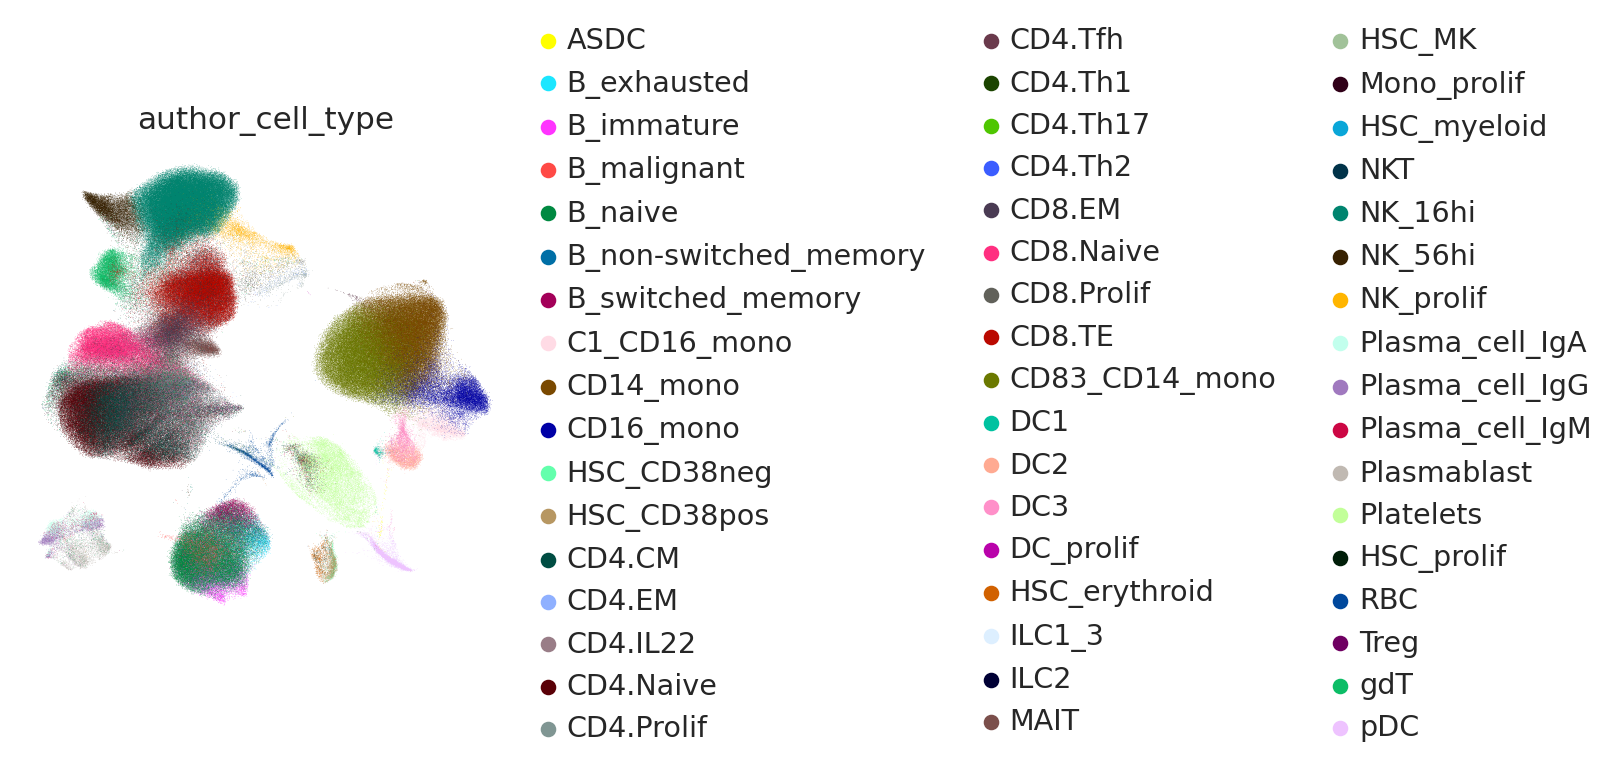

In [20]:
sc.pl.umap(adata, color='author_cell_type')

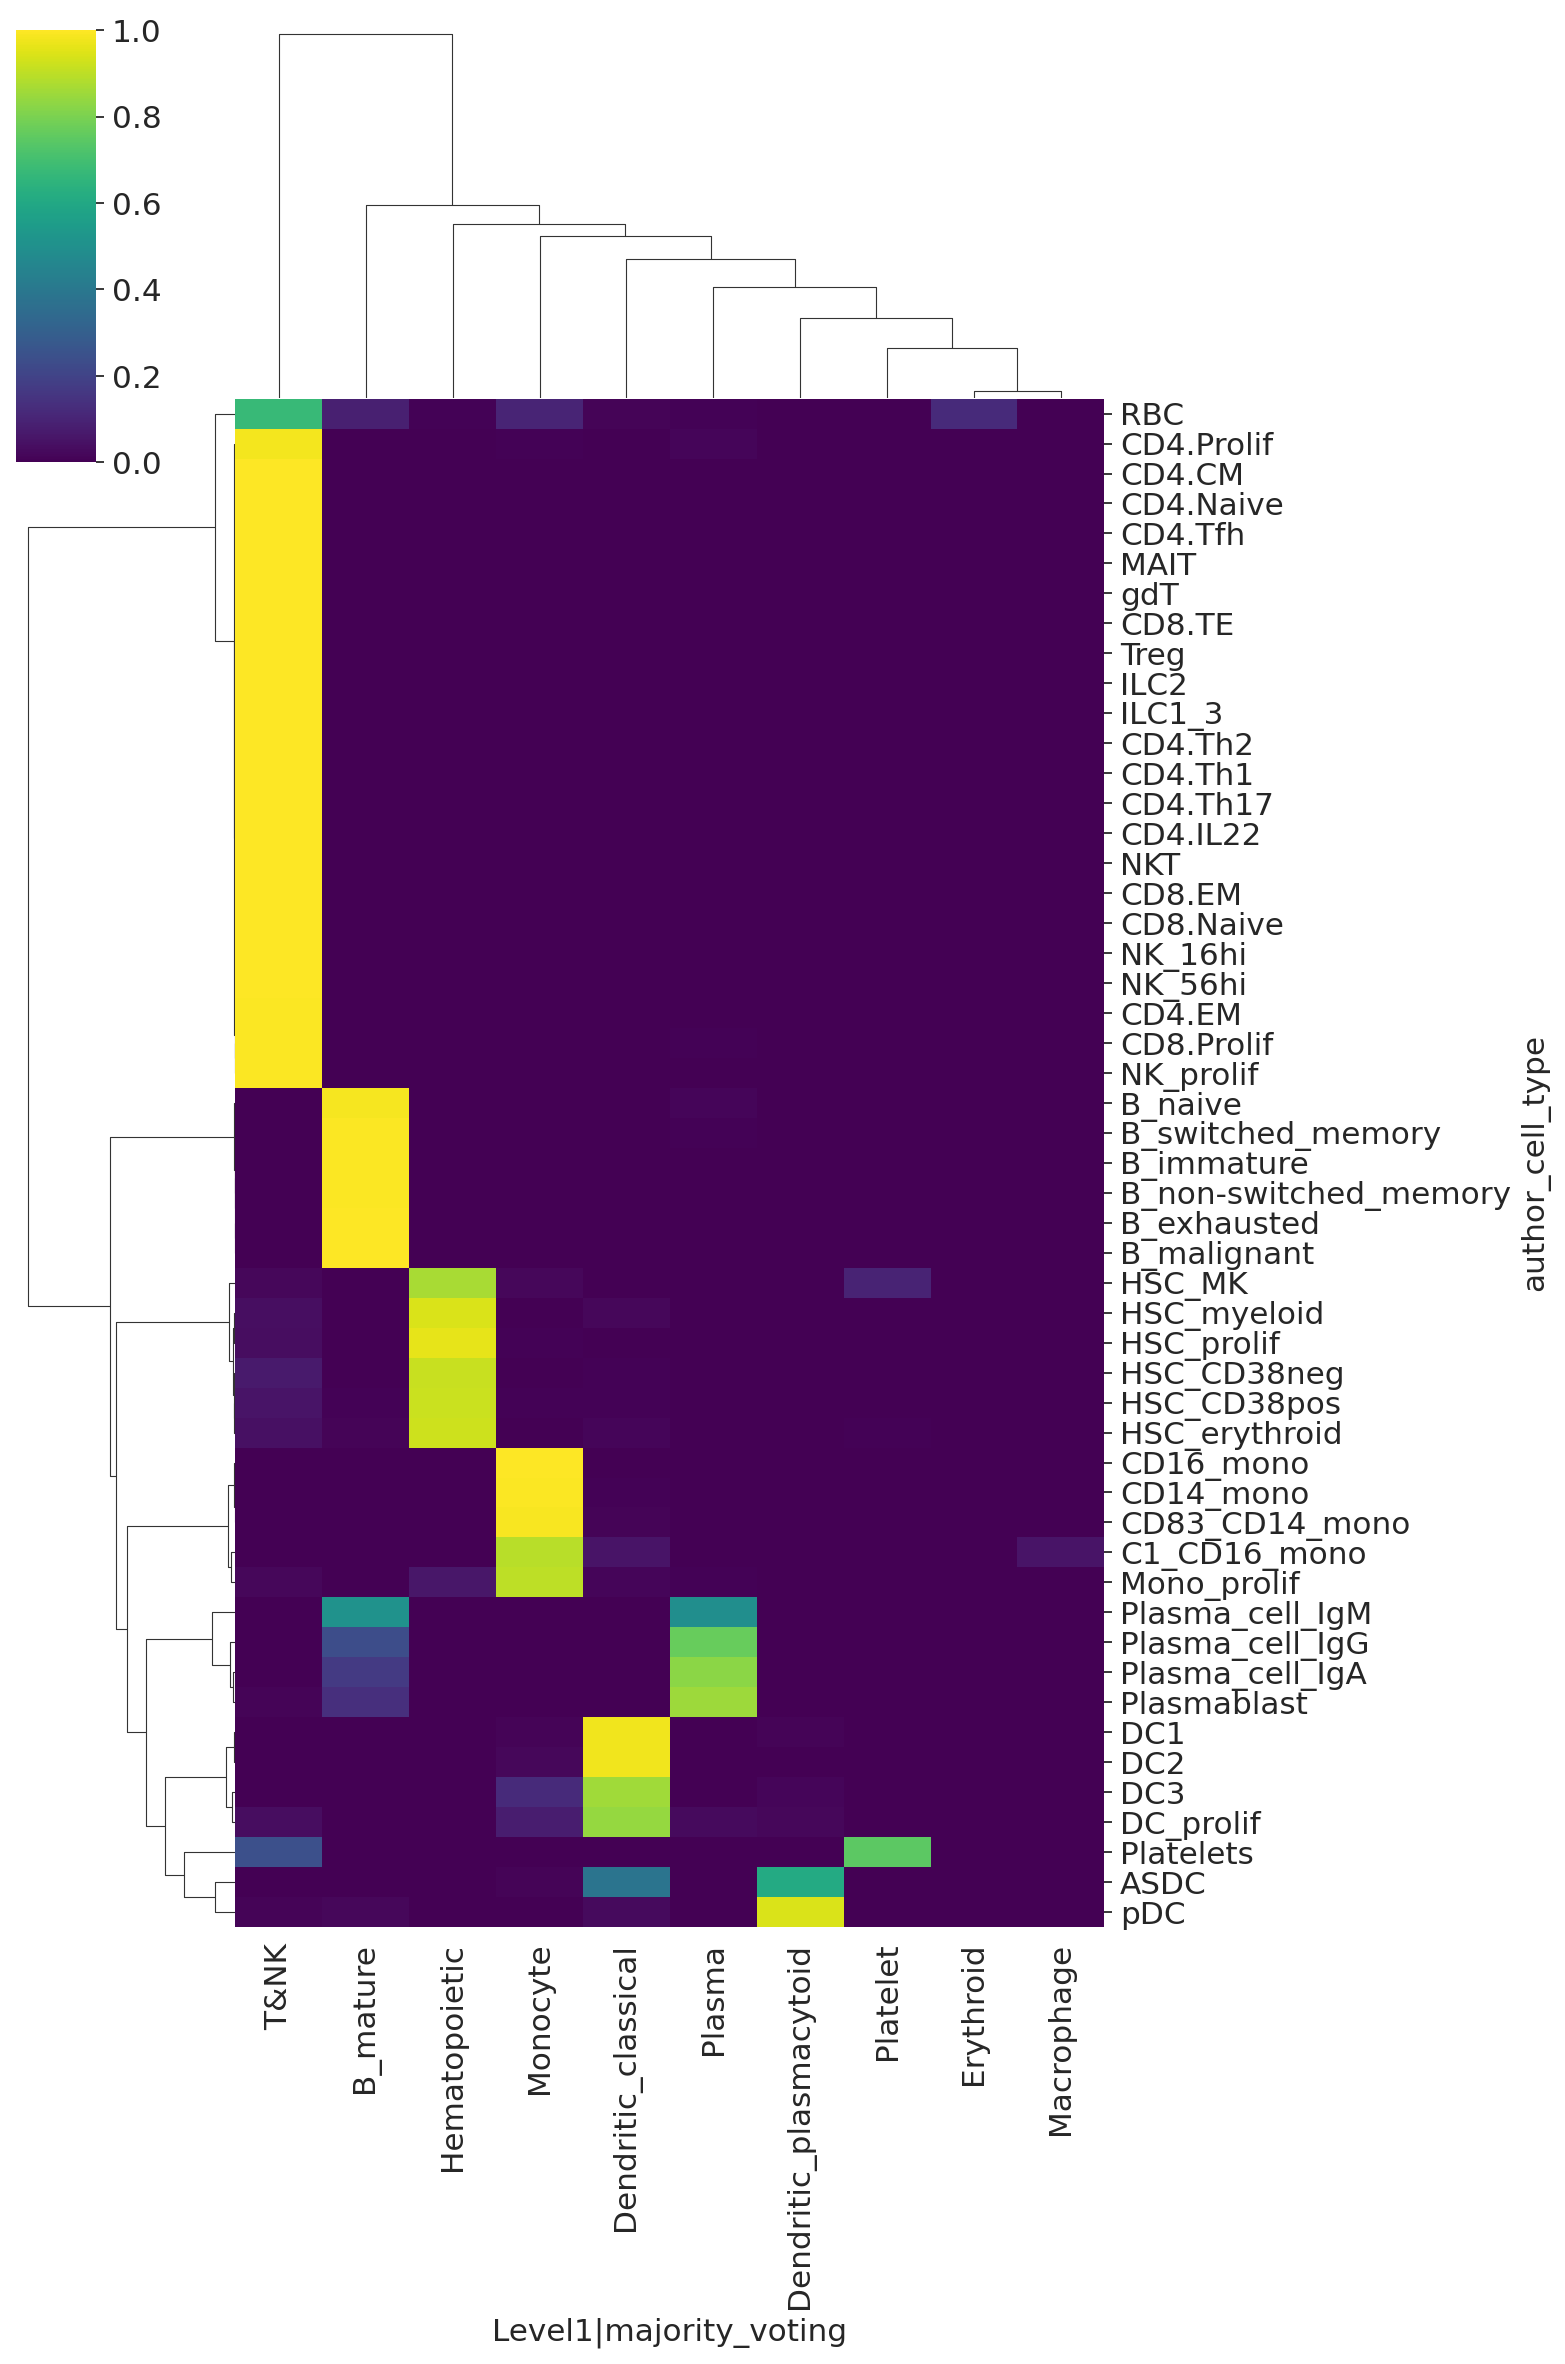

In [21]:
sns.clustermap(
    pd.crosstab(adata.obs['author_cell_type'], adata.obs['Level1|majority_voting'], normalize=0),
    method='ward',
    xticklabels=True, yticklabels=True,
    figsize=(10,15), cmap='viridis'
)

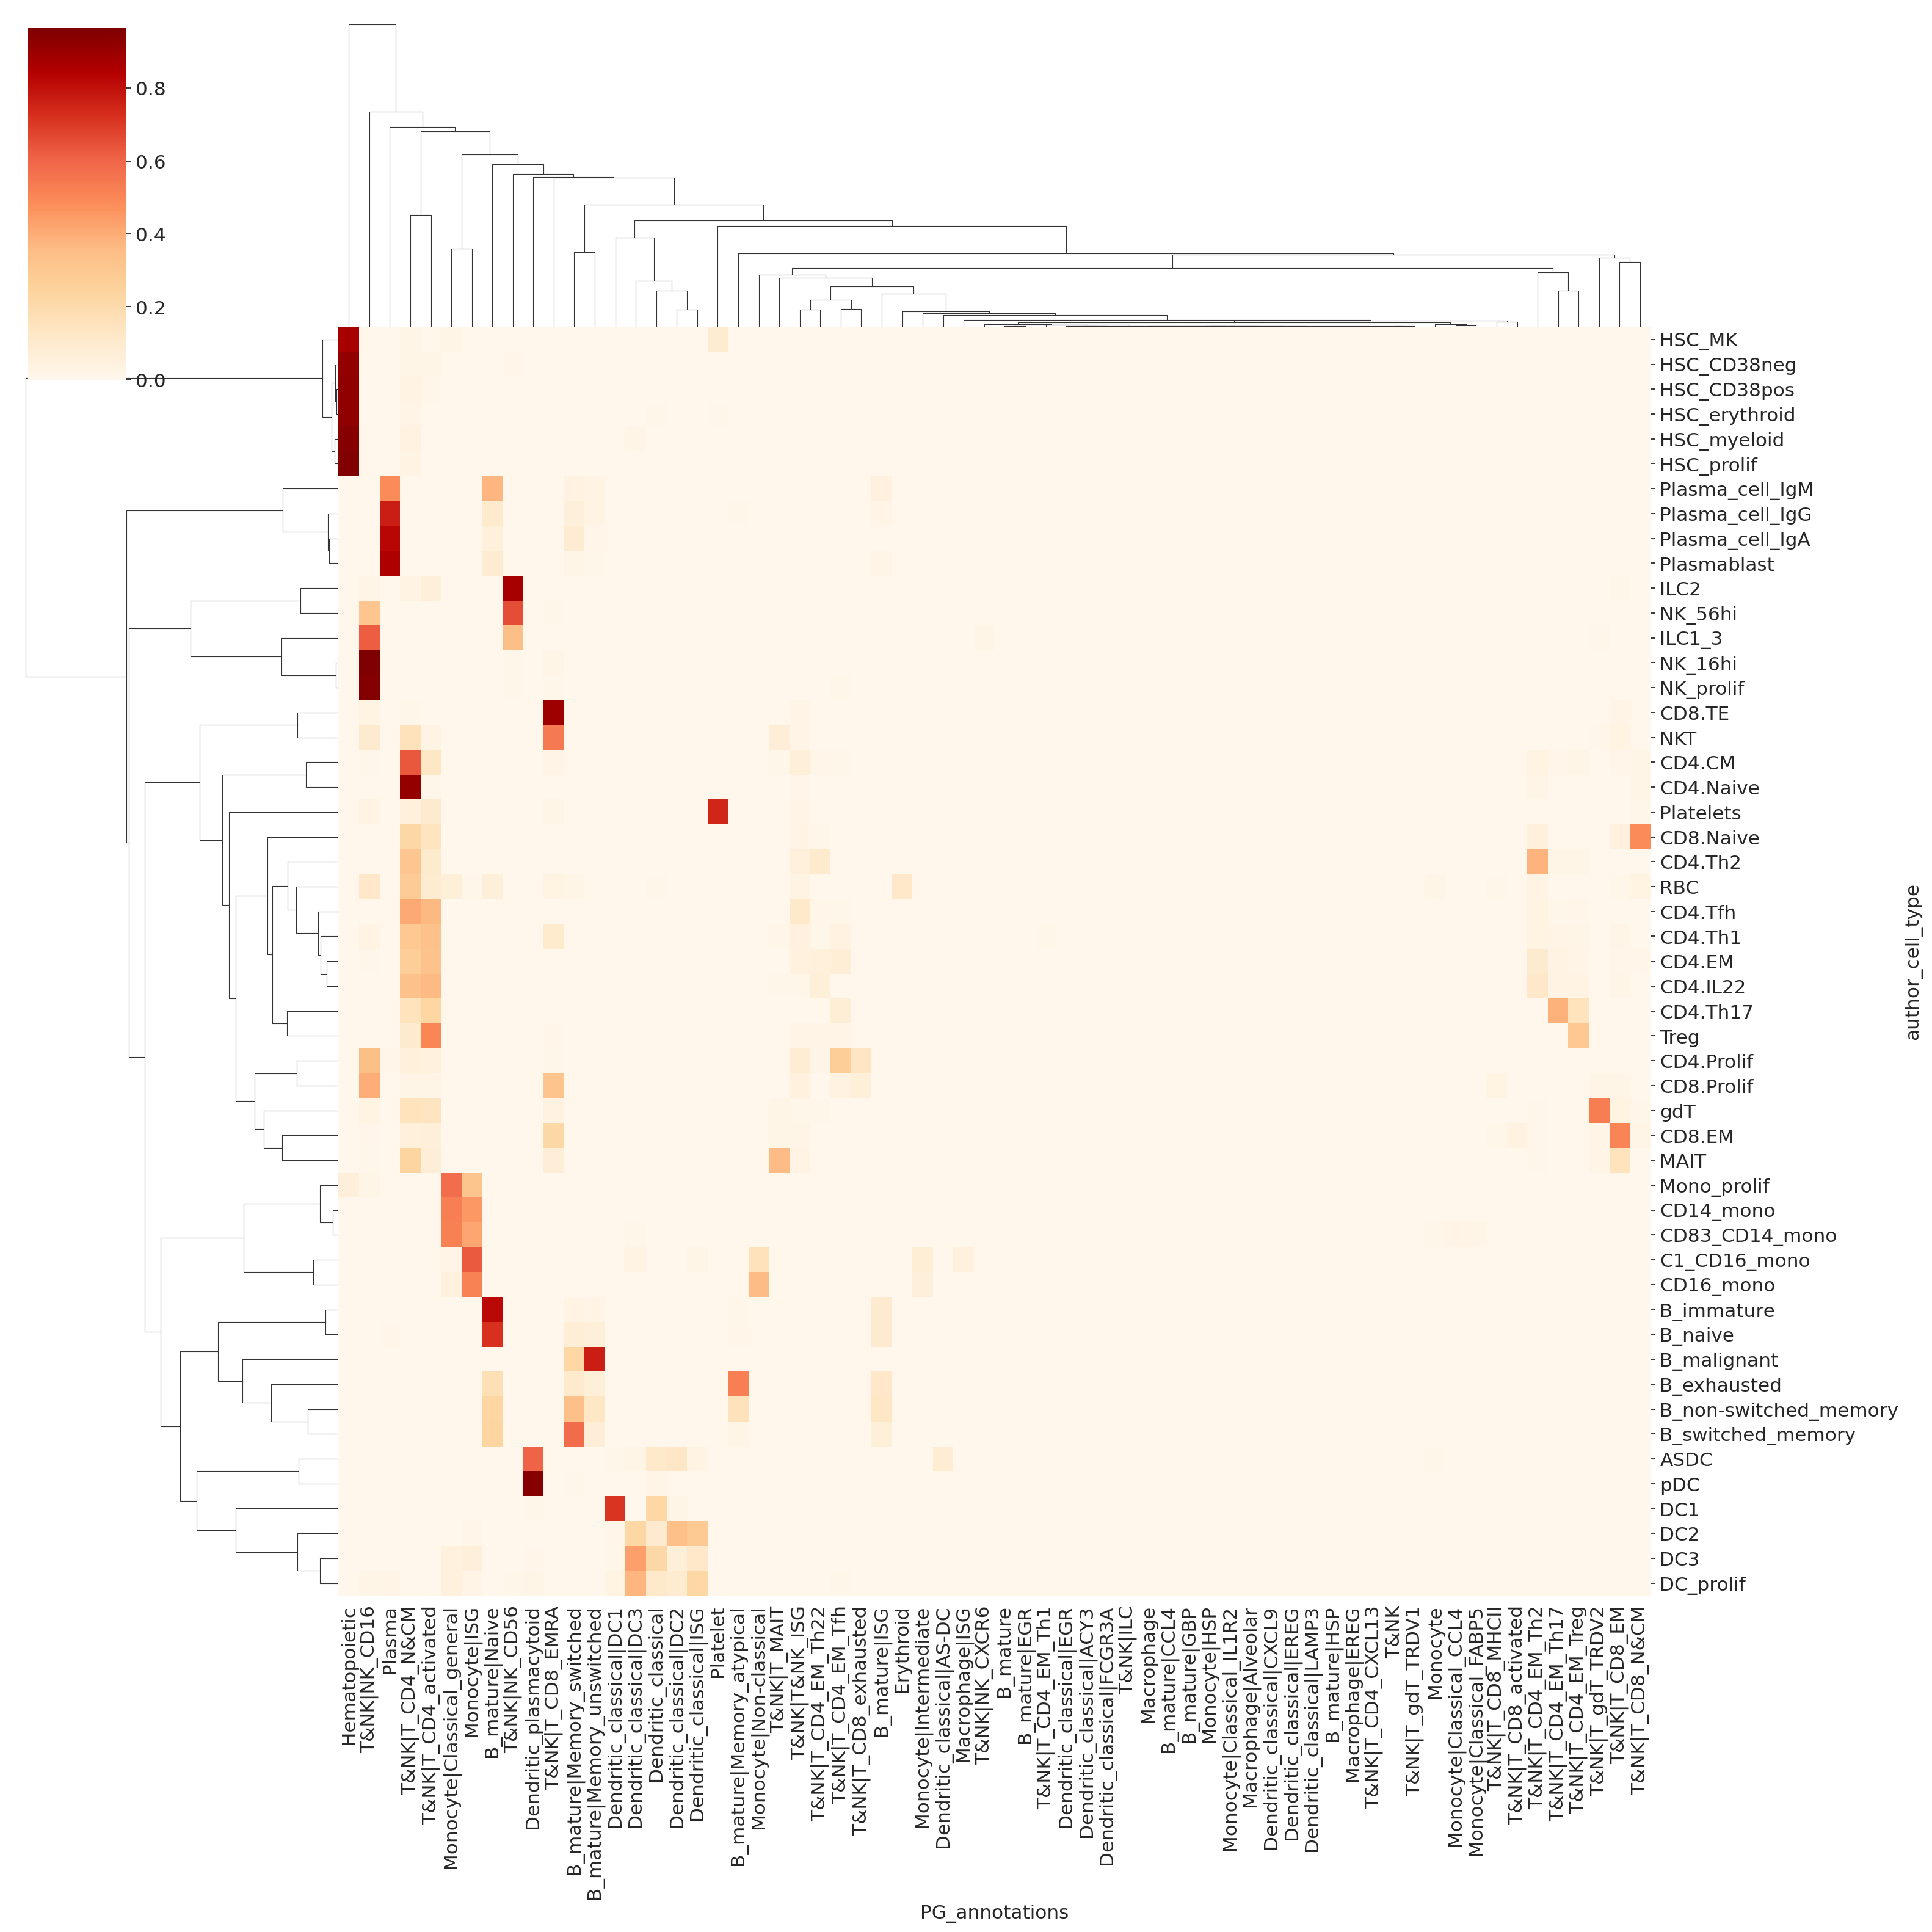

In [22]:
sns.clustermap(
    pd.crosstab(adata.obs['author_cell_type'], adata.obs['PG_annotations'], normalize=0),
    method='ward',
    xticklabels=True, yticklabels=True,
    figsize=(20,20), cmap = 'OrRd'
)

## Step 2 - Metadata annotation with PANGEApy

Once cell-level annotations are available, we can infer **sample-level metadata** using `MetaAnnotator`.  
This includes predictions for:

- **Organ of origin (`Organ_pred`)**
- **Transcriptomic phenotype (`Pheno_pred`)**

These predictions summarize each sample’s overall transcriptional identity based on its cell-type composition.

In [23]:
pred.head()

,Level1|predicted_labels,Level1|over_clustering,Level1|majority_voting,Level1|conf_score,Level1|cert_score,Level2|predicted_labels,Level2|over_clustering,Level2|majority_voting,Level2|conf_score,Level2|cert_score,PG_annotations,PG_combined_score,Sample
covid_index,,,,,,,,,,,,,
AAACCTGAGAAACCTA-MH9179824,T&NK,0,T&NK,0.999999,0.156115,T_CD8_EMRA,0,T_CD8_EMRA,0.999927,0.202715,T&NK|T_CD8_EMRA,0.999963,MH9179824
AAACCTGAGAGTAATC-MH9179824,T&NK,1,T&NK,0.999976,0.278088,T_CD4_EM_Th1,1,T_CD4_N&CM,0.885943,0.290980,T&NK|T_CD4_N&CM,0.941234,MH9179824
AAACCTGAGAGTGAGA-MH9179824,T&NK,3,T&NK,0.999976,0.402740,T_CD4_EM_Th22,1,T_CD4_N&CM,0.954359,0.457304,T&NK|T_CD4_N&CM,0.976901,MH9179824
AAACCTGAGGAATCGC-MH9179824,T&NK,4,T&NK,0.999999,0.193215,T_CD4_CXCL13,2,T_CD4_N&CM,0.495462,0.308035,T&NK|T_CD4_N&CM,0.703890,MH9179824
AAACCTGAGTGTTGAA-MH9179824,T&NK,7,T&NK,0.999999,0.337493,T_CD8_activated,4,T_CD4_N&CM,0.959132,0.186282,T&NK|T_CD4_N&CM,0.979352,MH9179824


In [24]:
# predict each sample's organ or transcriptomic phenotypes based on the universal cell annotation
meta = meta_anno.annotate(pred, sample_key='Sample')

In [25]:
meta

`meta.integrate` Integrates all sample-level meta annotation results into a single summary DataFrame.

In [26]:
# integrating results into a single dataframe
merged = meta.integrate()

In [27]:
merged.head()

,Organ_pred,Organ_prob,Pheno_pred,Pheno_prob
MH9143427,Blood,0.987191,BP5,0.963972
AP6,Blood,0.889799,BP4,0.984386
MH8919333,Blood,0.961722,BP1,0.758695
MH9143277,Blood,0.994699,BP7,0.610640
AP11,Blood,0.970142,BP9,0.999960


### Visualization of metadata predictions

The bar plots below show predicted organ and phenotype distributions across samples.

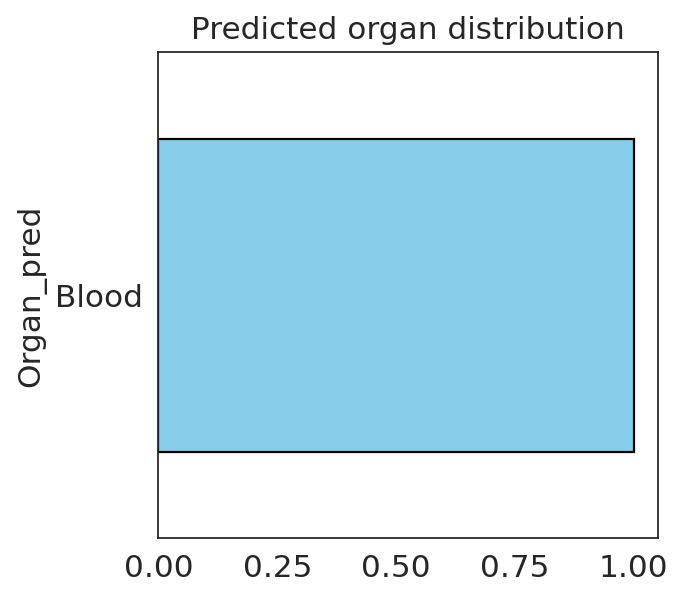

In [28]:
# Organ information prediction result
merged.value_counts('Organ_pred', normalize=True).plot.barh(
    stacked = True, width=0.9, linewidth=1, edgecolor='black', color='skyblue')
plt.title('Predicted organ distribution')
plt.show()

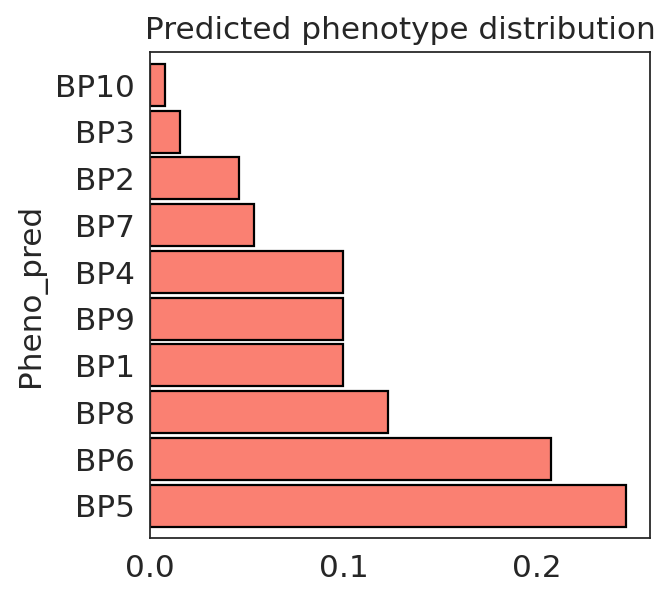

In [29]:
# Phenotype prediction result
merged.value_counts('Pheno_pred', normalize=True).plot.barh(
    stacked=True, width=0.9, linewidth=1, edgecolor='black', color='salmon')
plt.title('Predicted phenotype distribution')
plt.show()

### Validate predicted metadata against known clinical information

We next compare PANGEApy predictions with the clinical metadata provided in the original study.  
Specifically, we focus on the variable **`Status_on_day_collection_summary`**, which represents disease severity.

In [30]:
set(meta_df['Status_on_day_collection_summary'])

{'Asymptomatic',
 'Critical',
 'Healthy',
 'LPS_10hours',
 'LPS_90mins',
 'Mild',
 'Moderate',
 'Non_covid',
 'Severe'}

In [31]:
merged_meta = pd.merge(merged, meta_df, left_index=True, right_index=True, how='left')

In [32]:
merged_meta.value_counts('Status_on_day_collection_summary')

Status_on_day_collection_summary
Moderate        31
Mild            26
Healthy         24
Critical        17
Severe          14
Asymptomatic    11
Non_covid        5
LPS_90mins       3
LPS_10hours      3
Name: count, dtype: int64

For simplicity, we include only relevant categories of interest and visualize the phenotype distribution per severity group.

In [33]:
order = [
    'Healthy',
#     'Non_covid',
#     'LPS_90mins',
#     'LPS_10hours',
    'Asymptomatic',
    'Mild',
    'Moderate',
    'Severe',
    'Critical',
]

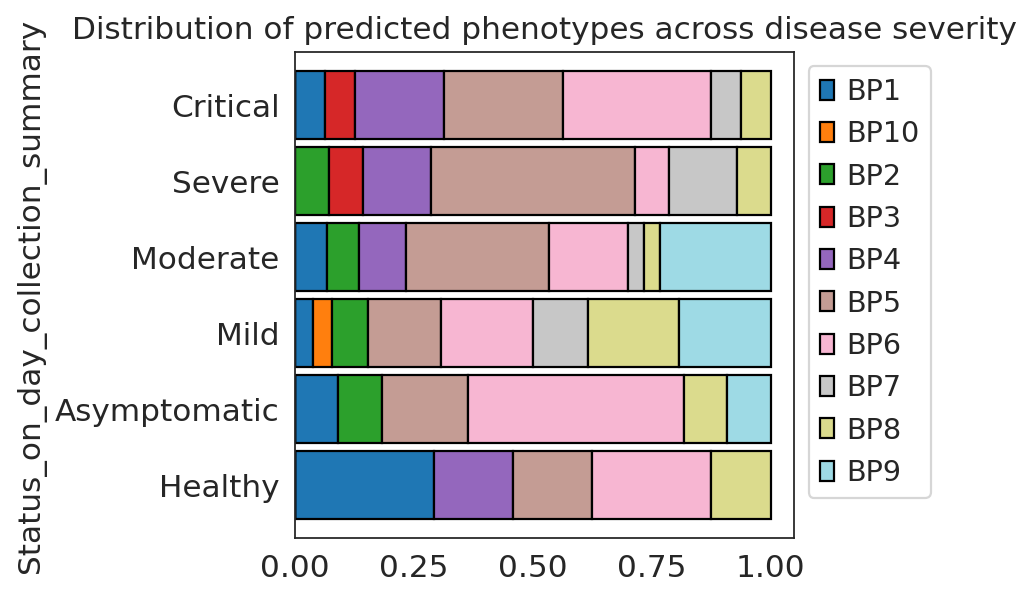

In [34]:
sub_merged_meta = merged_meta[merged_meta['Status_on_day_collection_summary'].isin(order)].copy()

result = pd.crosstab(sub_merged_meta['Status_on_day_collection_summary'], sub_merged_meta['Pheno_pred'], normalize=0)
result.loc[order].plot(kind='barh', stacked=True, cmap='tab20', width=0.9, linewidth=1, edgecolor='black')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Distribution of predicted phenotypes across disease severity')
plt.show()

As an example, we can inspect the relative abundance of a specific phenotype (e.g., **BP9**, an interferon-related immune activation state) across disease severity groups.

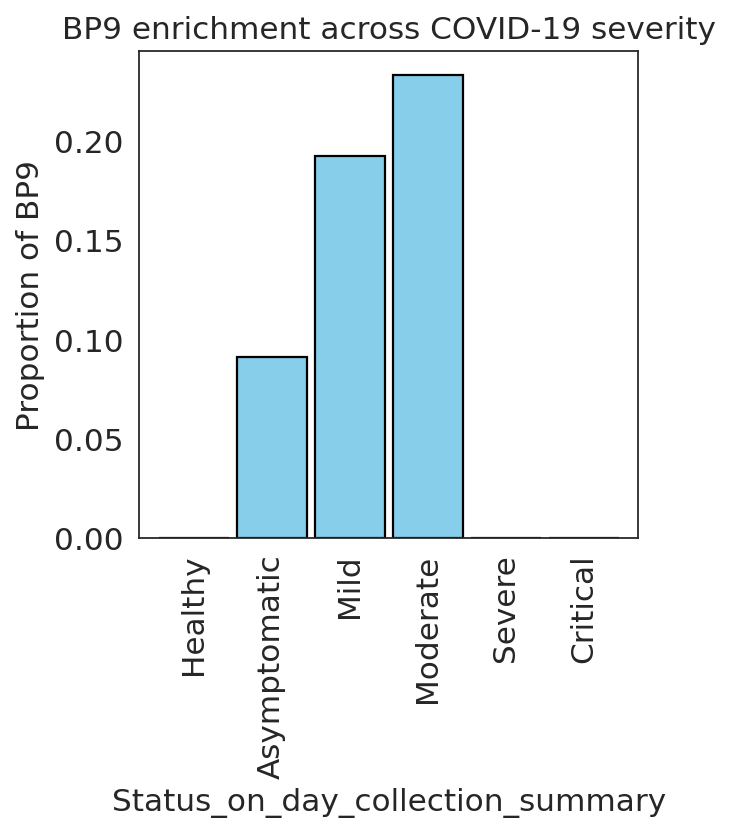

In [35]:
pd.crosstab(sub_merged_meta['Status_on_day_collection_summary'], sub_merged_meta['Pheno_pred'], 
            normalize=0).loc[order,'BP9'].plot.bar(stacked=True, width=0.9, linewidth=1, edgecolor='black', color='skyblue')
plt.ylabel('Proportion of BP9')
plt.title('BP9 enrichment across COVID-19 severity')
plt.show()

## Summary

This vignette demonstrated an end-to-end workflow for **cell and metadata annotation** using `PANGEApy`.

**Key takeaways:**
- Cell-level annotation enables harmonized labeling across public datasets using the universal PANGEA reference.  
- Metadata-level annotation infers organ and phenotype identity based on transcriptional composition.

## Package versions

In [24]:
sc.logging.print_header()

Package,Version
seaborn,0.13.2
pandas,2.3.3
scanpy,1.11.5
numpy,2.3.4
matplotlib,3.10.7
pangeapy,0.0
anndata,0.12.6
Component,Info
Python,"3.11.13 (main, Jun 5 2025, 13:12:00) [GCC 11.2.0]"
OS,Linux-5.4.0-150-generic-x86_64-with-glibc2.27
